In [43]:
import argparse
import os
import math
import numpy as np
import random
import struct
import matplotlib.pyplot as plt
import pickle  # Import pickle for serialization

In [44]:
class GillespieSelectionSimulation:
    def __init__(self, L, N, s, migration_matrix, tfinal, seed=None, l0=0):
        self.L = L  # Total number of demes
        self.N = N  # Number of individuals in each deme
        self.s = s  # Selection coefficient
        self.migration_matrix = migration_matrix
        self.tfinal = tfinal
        self.l0 = l0  # Initial location for the mutant
        np.random.seed(seed)  # Setting the random seed
        print('Initialization complete. Seed:', seed)

    def simulate(self):
        t = 0
        mutants = np.ones(self.L)  # Starting with 1 mutant in every deme for simplicity
        events = []
        mut_traj = [[t, mutants.copy()]]  # Initialize with the starting state

        print("Starting simulation...")
        while t < self.tfinal:

            if np.sum(mutants) == 0:
                print(f"All mutants extinct at time {t}. Reintroducing...")
                mutants = np.ones(self.L)
                t = 0
                events = []
                mut_traj = [[t, mutants.copy()]] 
                continue
            
                        
            f = mutants / self.N
            rate_mutant_replaces_wt = self.N * f * (1 - f) * (1 + self.s)
            rate_wt_replaces_mutant = self.N * f * (1 - f)
            rate_migration_mutant_to_i_from_j = np.zeros((self.L, self.L))
            rate_migration_wt_to_i_from_j = np.zeros((self.L, self.L))

            for i in range(self.L):
                for j in range(self.L):
                    if i != j:
                        # Calculate migration rates of mutants and wild types from j to i
                        rate_migration_mutant_to_i_from_j[i][j] = self.N * f[j] * (1 - f[i]) * (1 + self.s) * self.migration_matrix[i][j]
                        rate_migration_wt_to_i_from_j[i][j] = self.N * f[i] * (1 - f[j]) * self.migration_matrix[i][j]

            total_rate = np.sum(rate_mutant_replaces_wt + rate_wt_replaces_mutant) + \
                         np.sum(rate_migration_mutant_to_i_from_j) + np.sum(rate_migration_wt_to_i_from_j)

            if total_rate == 0:
                print("No possible reactions. Skipping...")
                break

            tau = np.random.exponential(scale=1 / total_rate)
            t += tau

            combined_rates = np.concatenate((rate_mutant_replaces_wt, rate_wt_replaces_mutant, 
                                             rate_migration_mutant_to_i_from_j.flatten(), rate_migration_wt_to_i_from_j.flatten()))
            reaction_probabilities = combined_rates / total_rate
            cumulative_prob = np.cumsum(reaction_probabilities)
            r = np.random.rand()
            reaction_index = np.where(cumulative_prob > r)[0][0]

            if reaction_index < self.L:
                event_type = 'M->W'
                updated_deme = reaction_index
                parent_deme = reaction_index
            elif reaction_index < 2 * self.L:
                event_type = 'W->M'
                updated_deme = reaction_index - self.L
                parent_deme = updated_deme
            elif reaction_index < 2 * self.L + self.L**2:
                event_type = 'Mig W->M'
                index = reaction_index - 2 * self.L
                i, j = index // self.L, index % self.L
                updated_deme = i
                parent_deme = j
                mutants[i] += 1
                # mutants[j] -= 1

            else:
                event_type = 'Mig M->W'
                index = reaction_index - (2 * self.L + self.L**2)
                i, j = index // self.L, index % self.L
                updated_deme = i
                parent_deme = j
                mutants[i] -= 1
                # mutants[j] += 1

            mut_traj.append([t, mutants.copy()])
            events.append([t, updated_deme, event_type, parent_deme])
            # print(f"Event at time {t}: {event_type} in deme {updated_deme}, from deme {parent_deme}")

        return events, mut_traj
    def save_events(self, events, filename):
        with open(filename, 'wb') as f:
            # Write the number of demes (L) and number of events as integers
            f.write(struct.pack('ii', self.L, len(events)))  # 'ii' indicates two integers
            pickle.dump(events, f)

    def load_events(self, filename):
        with open(filename, 'rb') as f:
            L, num_events = struct.unpack('ii', f.read(8))  # Read and unpack two integers
            events = pickle.load(f)
            return L, num_events, events

In [45]:
def plot_mutant_trajectories(mut_traj, L):
    times = [state[0] for state in mut_traj]
    mutant_counts = [state[1] for state in mut_traj]
    plt.figure(figsize=(10, 6))
    for deme in range(L):
        plt.plot(times, [m[deme] for m in mutant_counts], label=f'Deme {deme+1}')
    plt.xlabel('Time')
    plt.ylabel('Number of Mutants')
    plt.title('Mutant Trajectories Over Time')
    plt.legend()
    plt.show()


Initialization complete. Seed: None
Starting simulation...
All mutants extinct at time 39.90575002281606. Reintroducing...


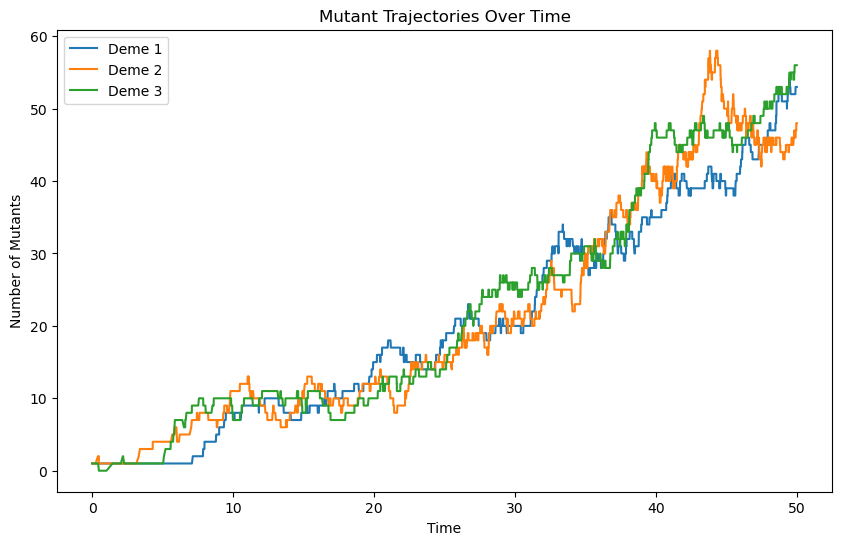

(3, 5791, [[0.03982753200734957, 2, 'M->W', 2], [0.08228806992790508, 0, 'W->M', 0], [0.13275514048592785, 2, 'M->W', 2], [0.19649868294445094, 2, 'W->M', 2], [0.2375626496115854, 1, 'W->M', 1], [0.4044125382277245, 1, 'Mig W->M', 2], [0.4152372912091571, 1, 'W->M', 1], [0.47042447516537794, 2, 'Mig M->W', 1], [0.4708487522517588, 1, 'Mig M->W', 0], [0.7714156265924476, 0, 'M->W', 0], [0.8749193724857763, 0, 'M->W', 0], [1.009584588801514, 0, 'W->M', 0], [1.442189470106003, 2, 'Mig W->M', 1], [1.610324241095909, 1, 'M->W', 1], [1.7902051519631086, 1, 'M->W', 1], [1.7970179683909289, 0, 'W->M', 0], [2.0280556766851165, 2, 'W->M', 2], [2.170210362869056, 2, 'Mig W->M', 1], [2.185545664546161, 2, 'M->W', 2], [2.264106000074633, 2, 'Mig M->W', 1], [2.293847172973204, 1, 'M->W', 1], [2.302872314222046, 1, 'M->W', 1], [2.5245526445292126, 0, 'M->W', 0], [2.915567779453926, 2, 'M->W', 2], [3.018707835280262, 1, 'W->M', 1], [3.135015595582218, 1, 'W->M', 1], [3.290832468583309, 1, 'Mig W->M', 

In [46]:
# Example usage
L = 3
N = 100
s = 0.25
migration_matrix = np.array([
    [0, 0.15, 0],
    [0.15, 0, 0.15],
    [0, 0.15, 0]
])

# migration_matrix = np.zeros((L, L))  # Example migration matrix

tfinal = 50
simulation = GillespieSelectionSimulation(L, N, s, migration_matrix, tfinal)
events, mut_traj = simulation.simulate()
plot_mutant_trajectories(mut_traj, L)
simulation.save_events(events, 'events.bin')
loaded_events = simulation.load_events('events.bin')

print(loaded_events)  # Optional: Print to verify contents

# print(mut_traj)
# for event in events:
#     print(event)  # Print each event



In [47]:

class MigrationMatrixGenerator:
    def __init__(self, deme_dimension, migration_rate):
        self.deme_dimension = deme_dimension
        self.migration_rate = migration_rate
    

    def generate_1Dmatrix(self):
        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            if i > 0:
                M[i, i - 1] = self.migration_rate
            if i < self.deme_dimension - 1:
                M[i, i + 1] = self.migration_rate

        return M
    
    
    def generate_2Dmatrix(self):
        """
        Generates a 2D migration matrix for a square grid of demes.
        Each deme can migrate to its immediate neighbors (up, down, left, right).
        Diagonal elements are set to 0, indicating no self-migration.
        """
        z = math.sqrt(self.deme_dimension)
        if not z.is_integer():
            raise ValueError("Deme dimension must be a perfect square for a 2D grid.")
        z = int(z)

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            for j in range(self.deme_dimension):
                # Check for right neighbor
                if j == i + 1 and (i + 1) % z != 0:
                    M[i, j] = self.migration_rate
                # Check for down neighbor
                elif j == i + z and j < self.deme_dimension:
                    M[i, j] = self.migration_rate

                # Ensure migration is bidirectional
                M[j, i] = M[i, j]

        return M

    def generate_3Dmatrix(self):
        """
        Generates a 3D migration matrix for a cubic grid of demes.
        Each deme can migrate to its immediate neighbors along the x, y, and z axes.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        cube_root = round(self.deme_dimension ** (1/3))
        if cube_root ** 3 != self.deme_dimension:
            raise ValueError("Deme dimension must be a cube number for a 3D grid.")

        M = np.zeros((self.deme_dimension, self.deme_dimension))

        for i in range(self.deme_dimension):
            x, y, z = np.unravel_index(i, (cube_root, cube_root, cube_root))

            # Check neighbors in each direction (left, right, up, down, front, back)
            for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                nx, ny, nz = x + dx, y + dy, z + dz
                if 0 <= nx < cube_root and 0 <= ny < cube_root and 0 <= nz < cube_root:
                    neighbor_index = np.ravel_multi_index((nx, ny, nz), (cube_root, cube_root, cube_root))
                    M[i, neighbor_index] = self.migration_rate

        return M

    def generate_island_model_matrix(self):
        """
        Generates a migration matrix based on the island model.
        Each deme has an equal migration rate to every other deme.
        Diagonal elements are set to 0, indicating no self-migration.
        """
        M = np.full((self.deme_dimension, self.deme_dimension), self.migration_rate)
        np.fill_diagonal(M, 0)  # Set diagonal elements to 0
        return M    

In [48]:
class DeterministicTrajectorySimulator:
    def __init__(self, L, N, frequencies):
        self.L = int(L)
        self.N = N
        self.frequencies = frequencies
        if len(frequencies) % L != 0:
            raise ValueError("Length of frequencies must be a multiple of the number of demes (L)")
        self.end_time = len(frequencies) // L
        self.timestep = 1 * self.N  #in generations
        # Initialize the attributes to store simulation results
        self.simulated_time = []
        self.simulated_allele_freqs = []
        # self.timecount = 0

    def simulate(self):
        self.simulated_time = []  # Resetting in case simulate is called multiple times
        self.simulated_allele_freqs = []  # Resetting as well
        forwards_t = 0
        backwards_t = 0
        position = len(self.frequencies) - self.L

        while forwards_t < self.end_time:
            # self.timecount += 1
            timestep_freqs = self.frequencies[position:position+self.L]
            self.simulated_allele_freqs.append(timestep_freqs)
            self.simulated_time.append(backwards_t)
            forwards_t += 1
            backwards_t += self.timestep
            position -= self.L
        return self.simulated_time, self.simulated_allele_freqs

        # No need to return since we're setting the attributes directly


    # def write_results_to_file(self, filename="simulation_results.bin"):
    #     with open(filename, 'wb') as file:
    #         # Write the number of demes (L) as a double
    #         file.write(struct.pack('d', float(self.L)))
    #         # Write the total number of timesteps as a double
    #         file.write(struct.pack('d', float(len(self.simulated_time))))
            
    #         # Write each timestep's data as doubles, including the time
    #         for t, freqs in zip(self.simulated_time, self.simulated_allele_freqs):
    #             # Pack and write the time as a double
    #             file.write(struct.pack('d', float(t)))
    #             # Then write the frequencies for this timestep as doubles
    #             for freq in freqs:
    #                 # Convert freqs to doubles and write
    #                 file.write(struct.pack('d', float(freq)))
